<a href="https://colab.research.google.com/github/nilaynishant/AIMLTutorial/blob/main/07_random_forest_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# run this only if you have not installed the requried packages
!pip install rasterio
!pip install geopandas
!pip install gitpython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import git

repo_url = 'https://github.com/nilaynishant/AIMLTutorial.git'  # set the URL of the repository
repo_dir = 'https://github.com/nilaynishant/AIMLTutorial/tree/main/Data'  # set the path to the local repository directory
if not os.path.exists('https://github.com/nilaynishant/AIMLTutorial/tree/main/Data'):
  git.Repo.clone_from(repo_url, repo_dir)
# variables 
# Note: labels should be always last column with name "labels"
# Note: Make sure input labels shapefile and input raster have same CRS, otherwise code will not run

# input files
raster_loc = '/content/https:/github.com/nilaynishant/AIMLTutorial/tree/main/Data/Data/Sentinel2_Agartala.tif'
points_loc = '/content/https:/github.com/nilaynishant/AIMLTutorial/tree/main/Data/Data/Training.gpkg'
temp_point_loc = '/content/https:/github.com/nilaynishant/AIMLTutorial/tree/main/Data/Data/temp_y_points.shp'

# land cover names (for post visualization)
lulc_name = ['Vegetation', 'Builtup', 'Water', 'Agriculture','Fallow']

#  reading bands from input
with rio.open(raster_loc) as img:
    bands = (img.read()).shape[0]
print('Bands of input image: ', bands)

# using ilteration to automatically create a bands list

features = []
for i in range(bands):
    features.append('band'+str(i+1))
print('Bands names: ', features)
f_len = len(features)

points = gpd.read_file(points_loc)
# adding a new column 'id' with range of points
points = points.assign(id1=range(len(points)))
# saving nenw point file with 'id'
points.to_file(temp_point_loc) 
# converting gdf to pd df and removing geometry
points_df = pd.DataFrame(points.drop(columns='geometry'))
# ilterating over multiband raster
sampled = pd.Series()

#inputShape= temp_point_loc
# Read input shapefile with fiona and iterate over each feature
with fiona.open(temp_point_loc) as shp:
    for feature in shp:
        siteID = feature['properties']['id1']
        coords = feature['geometry']['coordinates']
        # Read pixel value at the given coordinates using Rasterio
        # NB: `sample()` returns an iterable of ndarrays.
        with rio.open(raster_loc) as stack_src:
                  value = [v for v in stack_src.sample([coords])]
        # Update the pandas serie accordingly
        sampled.loc[siteID] = value
# reshaping sampled values
df1 = pd.DataFrame(sampled.values.tolist(), index=sampled.index)
df1['id1'] = df1.index
df1 = pd.DataFrame(df1[0].values.tolist(), 
                   columns=features)
df1['id1'] = df1.index

data = pd.merge(df1, points_df, on ='id1')
print('Sampled Data: \n',data)

x = data.iloc[:,0:f_len]
X = x.values
y = data.iloc[:,-1]
Y = y.values

import sklearn
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, stratify = Y)

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')

Bands of input image:  4
Bands names:  ['band1', 'band2', 'band3', 'band4']


<ipython-input-4-782f8aef36cf>:50: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sampled = pd.Series()


Sampled Data: 
      band1   band2   band3  band4  id1  id
0   2353.0   430.0   569.0  446.0    0   1
1   2664.0   500.0   601.0  446.0    1   1
2   2628.0   451.0   577.0  433.0    2   1
3   2335.0   481.0   613.0  476.0    3   1
4   2535.0   679.0   795.0  607.0    4   1
5   2839.0   449.0   575.0  472.0    5   1
6   2997.0   526.0   713.0  492.0    6   1
7   3023.0   462.0   688.0  518.0    7   1
8   3077.0   588.0   755.0  537.0    8   1
9   2839.0   522.0   603.0  455.0    9   1
10  1507.0  1058.0  1024.0  907.0   10   2
11  1832.0   826.0   882.0  717.0   11   2
12  1403.0  1194.0  1110.0  992.0   12   2
13  1416.0  1224.0  1072.0  952.0   13   2
14  1778.0   917.0   944.0  791.0   14   2
15  1588.0   940.0   958.0  857.0   15   2
16  1409.0   922.0   888.0  786.0   16   2
17  1477.0  1058.0   967.0  898.0   17   2
18  1668.0   891.0   883.0  760.0   18   2
19  1691.0  1102.0  1050.0  903.0   19   2
20   520.0   530.0   661.0  559.0   20   3
21   650.0   689.0   933.0  689.0   21

In [5]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

cName = 'RF'


clf = RandomForestClassifier()
clf.fit(X_train, y_train)


CPU times: user 246 ms, sys: 27.2 ms, total: 273 ms
Wall time: 415 ms


RandomForestClassifier()

<Axes: >

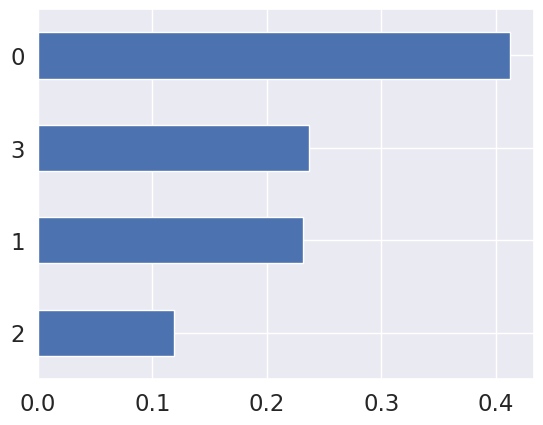

Accuracy RF: 87.5
              precision    recall  f1-score   support

           1       1.00      0.67      0.80         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       0.75      0.75      0.75         4
           5       0.75      1.00      0.86         3

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.88        16
weighted avg       0.89      0.88      0.87        16

Confusion Matrix RF: 
 [[2 0 0 1 0]
 [0 3 0 0 0]
 [0 0 3 0 0]
 [0 0 0 3 1]
 [0 0 0 0 3]]


Text(45.74999999999999, 0.5, 'Actual')

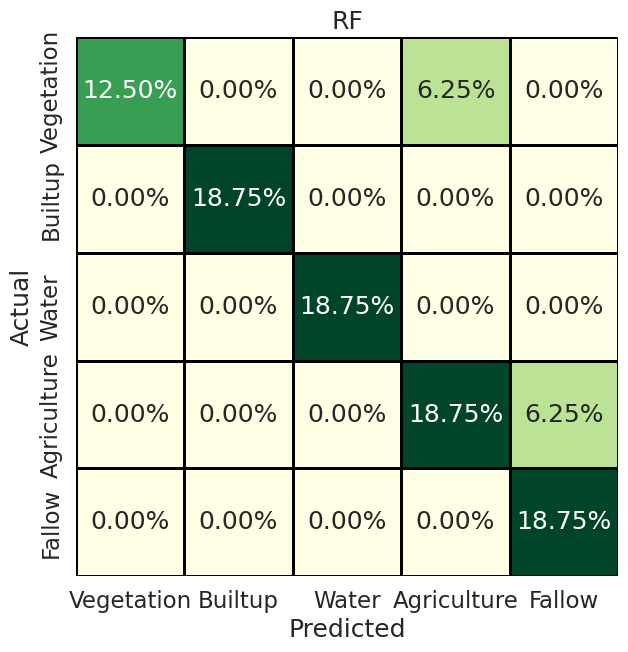

In [6]:

clf_pred = clf.predict(X_test)

print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*100}")
print(classification_report(y_test, clf_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = cm/np.sum(cm)

plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(cm_percent,
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            cmap="YlGn",
            annot=True,
            fmt='.2%',
            cbar=False,
            linewidths=2,
            linecolor='black')

plt.title(cName)
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig(f'../figs/confusion_matrix_{cName}.png', dpi=300, bbox_inches='tight')

In [7]:
%%time

cName = 'RF'
exp_name = f'lulc_{cName}.tif'


img = rio.open(raster_loc)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, f_len)
print('reshaped full data shape  for prediction: ',img_n.shape)


pred_full = clf.predict(img_n)

print('Prediction Done, now exporting raster \n')
# Predefining out raster meta using variable raster
tempfile_arr = img.read(1)
tempfile_arr = tempfile_arr.reshape(-1,1)
metadata = img.meta

height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')

img_reshape = pred_full.reshape(height, width)

out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1,
                                          dtype='uint8',
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()

print(f'Map saved {cName}.................')

Height: 1938
Width: 2202
Bands: 4

reshaped full data shape  for prediction:  (4267476, 4)
Prediction Done, now exporting raster 

Map saved RF.................
CPU times: user 29.4 s, sys: 6.63 s, total: 36.1 s
Wall time: 40.7 s


In [ ]:
import pandas as pd
feature_importance = pd.Series(clf.feature_importances_).sort_values()
feature_importance.plot(kind='barh')